<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Introducción al Aprendizaje Automático -> Grupo 10 Cohorte 2</h1>

Rodrigo Bertoya

Agustin Mauras Velez 

Gabriel Moyano

Marcelo Tisera

Silvia Pierotti

Fernandez María Soledad   

# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
# fijo semillas aleatorias para SGDClassifier y para DecisionTreeClassifier
ranstate = 1

In [3]:
# defino función para calcular los scores
def all_scores(y_train,y_test,y_train_pred,y_test_pred):
    sol=np.zeros((8,1))

    sol[0] = accuracy_score(y_train, y_train_pred)
    sol[1] = accuracy_score(y_test, y_test_pred)
    sol[2] = precision_score(y_train, y_train_pred, zero_division=0)
    sol[3] = precision_score(y_test, y_test_pred, zero_division=0)
    sol[4] = recall_score(y_train, y_train_pred, zero_division=0)
    sol[5] = recall_score(y_test, y_test_pred, zero_division=0)
    sol[6] = f1_score(y_train, y_train_pred)
    sol[7] = f1_score(y_test, y_test_pred)

    df = pd.DataFrame(sol, index=['ACCURACY_TRAIN','ACCURACY_TEST','PRECISION_TRAIN','PRECISION_TEST','RECALL_TRAIN','RECALL_TEST','F1_TRAIN','F1_TEST'])
    df.columns = ['Score']
    
    return df

In [4]:
def all_scores_vs(y_train,y_test,y_train_pred,y_test_pred,y_train_pred_bestpar,y_test_pred_bestpar):
    df1 = all_scores(y_train,y_test,y_train_pred_bestpar,y_test_pred_bestpar)
    df2 = all_scores(y_train,y_test,y_train_pred,y_test_pred)
    df = pd.concat([df1, df2], axis=1)
    df.columns = ['ScoreBestPar','ScoreDefault']
    return df

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [5]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

In [6]:
dataset

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001


In [7]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

In [8]:
X.shape, y.shape

((1854, 10), (1854,))

In [9]:
# división aleatoria entre entrenamiento y evaluación, dejando 80% de los datos para entrenamiento y 20% para test
X_train_o, X_test_o, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# El Descenso de gradiente estocástico es sensible al escalado de características, por lo que es muy recomendable escalar 
# sus datos. Por ejemplo, escale cada atributo en el vector de entrada X a [0,1] o [-1, + 1], 
# o estandarícelo para que tenga media 0 y varianza 1
scaler = StandardScaler()
scaler.fit(X_train_o)  
X_train = scaler.transform(X_train_o)
X_test = scaler.transform(X_test_o)

In [11]:
X_train.shape, y_train.shape

((1483, 10), (1483,))

In [12]:
X_test.shape, y_test.shape

((371, 10), (371,))

### Conjunto de Entrenamiento 
1483 registros

### Conjunto de Test
371 registros


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

### 1.1 ¿De qué se trata el conjunto de datos?

### Contexto
El departamento de crédito al consumo de un banco quiere automatizar la toma de decisiones.
Se necesita un proceso para la aprobación de líneas de crédito con garantía hipotecaria. Para hacer esto, lo harán
siguiendo las recomendaciones de la Ley de Igualdad de Oportunidades de Crédito para crear un
modelo de calificación crediticia empíricamente derivado y estadísticamente sólido. El modelo
se basará en datos recopilados de solicitantes recientes a los que se les haya otorgado crédito a través del proceso actual de suscripción de préstamos. El modelo se construirá a partir de herramientas de modelado predictivo, pero el modelo creado debe ser lo suficientemente interpretable como para proporcionar una razón para cualquier acción adversa (rechazo).

### Contenido

El conjunto de datos Home Equity (HMEQ) contiene información sobre la línea de base y el rendimiento del préstamo
para 5,960 préstamos recientes con garantía hipotecaria. El objetivo  o TARGET (BAD) es un binario
variable que indica si un solicitante finalmente incumplió o fue
seriamente delincuente. Este resultado adverso ocurrió en 1.189 casos (20%). por
cada solicitante, se registraron 12 variables de entrada.

### 1.2 ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

La variable objetivo a predecir es TARGET que indica si de acuerdo a las features seleccionadas hay posibilidades o no en el incumplimiento del pago de un prestamo a otorgar.

### 1.3 ¿Qué información (atributos) hay disponible para hacer la predicción?

### Features


- Etiqueta TARGET: 1 = cliente con inclumplimiento en el préstamo - 0 = préstamo pagado
- LOAN Monto de la solicitud de préstamo
- MORTDUE Monto incumplido debido a la hipoteca existente
- VALUE Valor de la propiedad actual
- YOJ Años en el trabajo actual
- DEROG Número de informes peyorativos importantes
- DELINQ Número de líneas de crédito morosas
- CLAGE Edad de la línea comercial más antigua en meses
- NINQ Número de líneas de crédito recientes
- CLNO Número de líneas de crédito
- DEBTINC Relación deuda / ingresos


### 1.4 ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

A priori podemos decir que los atributos desde nuestro punto de vista determinantes para la predicción son:

- LOAN
- DEBTINC
- YOJ
- DELINQ

**No hace falta escribir código para responder estas preguntas.**

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [13]:
model = SGDClassifier(random_state=ranstate)

In [14]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#### Metricas del Modelo por Defecto

In [15]:
#Entrenamiento Predicciones Correctas
(y_train == y_train_pred).sum(), (y_train != y_train_pred).sum()

(1285, 198)

In [16]:
#Test Predicciones Correctas
(y_test == y_test_pred).sum(), (y_test != y_test_pred).sum()

(321, 50)

#### Precision

$$Precision = \frac{|Train \cap Test|}{|Train|} = \frac{TP}{TP + FP}$$

#### Recall

$$Recall = \frac{|Train \cap Test|}{|Test|} = \frac{TP}{TP + FN}$$

#### F1

$$F_1 = \frac{2 * Precision * Recall}{Precision + Recall}$$

In [17]:
df_sgd_d = all_scores(y_train,y_test,y_train_pred,y_test_pred)
display(df_sgd_d)

print('Matriz de Confusion de Entrenamiento')
print(confusion_matrix(y_train, y_train_pred))
print('Matriz de Confusion de Evaluación')
print(confusion_matrix(y_test, y_test_pred))

,Score
ACCURACY_TRAIN,0.866487
ACCURACY_TEST,0.865229
PRECISION_TRAIN,0.680272
PRECISION_TEST,0.633333
RECALL_TRAIN,0.398406
RECALL_TEST,0.327586
F1_TRAIN,0.502513
F1_TEST,0.431818


Matriz de Confusion de Entrenamiento
[[1185   47]
 [ 151  100]]
Matriz de Confusion de Evaluación
[[302  11]
 [ 39  19]]


### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [18]:
#SGDClassifier??

#### Definicion de Hiper Parametros

In [19]:
# Definiciones de hiper parametros
param_grid = {
    'loss': [ # The loss function to be used. Defaults to 'hinge'
        'hinge',        # SVM
        'modified_huber', # Otra version de regresion logistica
        'log',          # logistic regression
        'squared_hinge'  # SVM cuadraticamente penalizado
    ],
    'eta0': [1e-16,1e-8,1e-4,1e-2], # The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. The default value is 0.0 as eta0 is not used by the default schedule ‘optimal’
    'alpha': [1e-6,1e-5,1e-4,1e-3,1e-2], # Constant that multiplies the regularization term. Default = 1e-4
    #'max_iter' : [1000,1500], # The maximum number of passes over the training data. Default = 1000
    'early_stopping' : [False,True], # Whether to use early stopping to terminate training when validation score is not improving. Default = False    
    'learning_rate': [ # The learning rate schedule. Defaults to 'optimal'
        'constant',
        'optimal',
        'invscaling',
        'adaptive'
    ],
    'random_state': [0,1,2,3,4] # Used for shuffling the data
}

#### Aplicacion de Hiper Parametros

In [20]:
model = SGDClassifier()

In [21]:
#cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
cv = GridSearchCV(model, param_grid, scoring='precision', cv=5)

#### Entrenar el Modelo

In [22]:
warnings.filterwarnings('ignore')
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01],
                         'early_stopping': [False, True],
                         'eta0': [1e-16, 1e-08, 0.0001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['hinge', 'modified_huber', 'log',
                                  'squared_hinge'],
                         'random_state': [0, 1, 2, 3, 4]},
             scoring='precision')

#### Verificacion Resultados del Entrenamiento

In [23]:
results = cv.cv_results_
    
df = pd.DataFrame(results)
df_result = df[['param_loss', 'param_alpha', 'param_learning_rate', 'param_random_state', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_result

,param_loss,param_alpha,param_learning_rate,param_random_state,mean_test_score,std_test_score,rank_test_score
0,hinge,1e-06,constant,0,0.683015,0.098495,1958
1,hinge,1e-06,constant,1,0.683015,0.098495,1958
2,hinge,1e-06,constant,2,0.683015,0.098495,1958
3,hinge,1e-06,constant,3,0.683015,0.098495,1958
4,hinge,1e-06,constant,4,0.683015,0.098495,1958
...,...,...,...,...,...,...,...
3195,squared_hinge,0.01,adaptive,0,0.838817,0.050141,194
3196,squared_hinge,0.01,adaptive,1,0.816349,0.076809,359
3197,squared_hinge,0.01,adaptive,2,0.799113,0.076798,623
3198,squared_hinge,0.01,adaptive,3,0.815507,0.056200,361


#### Seleccionar el Mejor Modelo

In [24]:
# Seleccionar el modelo con mean_test_score mas alto y menor varianza
df_bm = df_result[df_result['rank_test_score'] == 1]
df_bm

,param_loss,param_alpha,param_learning_rate,param_random_state,mean_test_score,std_test_score,rank_test_score
3124,hinge,0.01,constant,4,0.917483,0.049131,1


In [25]:
# Mejor modelo

best_model = cv.best_estimator_
bestpar = cv.best_params_

print('Mejor Modelo\n', best_model)
print('Mejores Parametros\n', bestpar)

Mejor Modelo
 SGDClassifier(alpha=0.01, early_stopping=True, eta0=0.01,
              learning_rate='constant', random_state=4)
Mejores Parametros
 {'alpha': 0.01, 'early_stopping': True, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 4}


#### Predecir con el Modelo Seleccionado

In [26]:
y_train_pred_bestpar = best_model.predict(X_train)
y_test_pred_bestpar = best_model.predict(X_test)

#### Calcular Metricas para Dataset de Entrenamiento y Test

In [27]:
df_sgd_bm = all_scores_vs(y_train,y_test,y_train_pred,y_test_pred,y_train_pred_bestpar,y_test_pred_bestpar)
display(df_sgd_bm)

print('Matriz de Confusion de Entrenamiento con par. óptimos')
print(confusion_matrix(y_train, y_train_pred_bestpar))
print('Matriz de Confusion de Evaluación con par. óptimos')
print(confusion_matrix(y_test, y_test_pred_bestpar))

,ScoreBestPar,ScoreDefault
ACCURACY_TRAIN,0.871207,0.866487
ACCURACY_TEST,0.881402,0.865229
PRECISION_TRAIN,0.884615,0.680272
PRECISION_TEST,0.888889,0.633333
RECALL_TRAIN,0.274900,0.398406
RECALL_TEST,0.275862,0.327586
F1_TRAIN,0.419453,0.502513
F1_TEST,0.421053,0.431818


Matriz de Confusion de Entrenamiento con par. óptimos
[[1223    9]
 [ 182   69]]
Matriz de Confusion de Evaluación con par. óptimos
[[311   2]
 [ 42  16]]


## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

In [28]:
#DecisionTreeClassifier??

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [29]:
model_dt = DecisionTreeClassifier(random_state=ranstate)

X_train = X_train_o
X_test = X_test_o

model_dt.fit(X_train, y_train)
y_train_pred = model_dt.predict(X_train)
y_test_pred = model_dt.predict(X_test)

#### Metricas con el Modelo por Defecto

In [31]:
df_dt_d = all_scores(y_train,y_test,y_train_pred,y_test_pred)
display(df_dt_d)

print('Matriz de Confusion de Entrenamiento')
print(confusion_matrix(y_train, y_train_pred))
print('Matriz de Confusion de Evaluación')
print(confusion_matrix(y_test, y_test_pred))

,Score
ACCURACY_TRAIN,1.000000
ACCURACY_TEST,0.889488
PRECISION_TRAIN,1.000000
PRECISION_TEST,0.666667
RECALL_TRAIN,1.000000
RECALL_TEST,0.586207
F1_TRAIN,1.000000
F1_TEST,0.623853


Matriz de Confusion de Entrenamiento
[[1232    0]
 [   0  251]]
Matriz de Confusion de Evaluación
[[296  17]
 [ 24  34]]


### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Definicion de Hiper Parametros

In [32]:
# Definiciones de hiper parametros

param_grid_dt = {
     'criterion': ['gini', 'entropy'], # default="gini" The function to measure the quality of a split
     'max_depth': list(range(1,15)), # default=None The maximum depth of the tree
     'min_samples_leaf': list(range(1,15)), # default=1 The minimum number of samples required to be at a leaf node
     'max_features' : [None,'auto','sqrt','log2',0.5], # default=None The number of features to consider when looking for the best split
     'random_state':  [0,1,2,3,4]   
}

#### Aplicacion de Hiper Parametros

In [33]:
model_dt = DecisionTreeClassifier()
cv_dt = GridSearchCV(model_dt, param_grid_dt, scoring='accuracy', cv=5)
#cv_dt = GridSearchCV(model_dt, param_grid_dt, scoring='precision', cv=5)

#### Entrenar el Modelo

In [34]:
warnings.filterwarnings('ignore')
cv_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'max_features': [None, 'auto', 'sqrt', 'log2', 0.5],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14],
                         'random_state': [0, 1, 2, 3, 4]},
             scoring='accuracy')

#### Verificar resultados de Entrenamiento

In [35]:
results = cv_dt.cv_results_
    
df = pd.DataFrame(results)
df_result = df[['param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'param_random_state', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_result

,param_criterion,param_max_depth,param_min_samples_leaf,param_random_state,mean_test_score,std_test_score,rank_test_score
0,gini,1,1,0,0.869194,0.009254,5209
1,gini,1,1,1,0.869194,0.009254,5209
2,gini,1,1,2,0.869194,0.009254,5209
3,gini,1,1,3,0.869194,0.009254,5209
4,gini,1,1,4,0.869194,0.009254,5209
...,...,...,...,...,...,...,...
9795,entropy,14,14,0,0.865825,0.011822,7078
9796,entropy,14,14,1,0.857737,0.014204,8605
9797,entropy,14,14,2,0.865829,0.022628,7063
9798,entropy,14,14,3,0.875940,0.012575,1886


#### Seleccionar el mejor Modelo

In [36]:
# Seleccionar el modelo con mean_test_score mas alto y menor varianza
df_bm_dt = df_result[df_result['rank_test_score'] == 1]
df_bm_dt

,param_criterion,param_max_depth,param_min_samples_leaf,param_random_state,mean_test_score,std_test_score,rank_test_score
4277,gini,13,2,2,0.894149,0.022948,1
4347,gini,13,2,2,0.894149,0.022948,1
4417,gini,13,2,2,0.894149,0.022948,1


In [37]:
# Mejor modelo

best_model_dt = cv_dt.best_estimator_
bestpar_dt = cv_dt.best_params_

print('Mejor Modelo\n', best_model_dt)
print('Mejores Parametros\n', bestpar_dt)

Mejor Modelo
 DecisionTreeClassifier(max_depth=13, max_features='auto', min_samples_leaf=2,
                       random_state=2)
Mejores Parametros
 {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2, 'random_state': 2}


#### Predecir con el Modelo Seleccionado

In [38]:
y_train_pred_bestpar = best_model_dt.predict(X_train)
y_test_pred_bestpar = best_model_dt.predict(X_test)

#### Calcular Metricas para Dataset de Entrenamiento y Test

In [40]:
df_dt_bm = all_scores_vs(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_bestpar, y_test_pred_bestpar)
display(df_dt_bm)

print('Matriz de Confusion de Entrenamiento con par. óptimos')
print(confusion_matrix(y_train, y_train_pred_bestpar))
print('Matriz de Confusion de Evaluación con par. óptimos')
print(confusion_matrix(y_test, y_test_pred_bestpar))

,ScoreBestPar,ScoreDefault
ACCURACY_TRAIN,0.946055,1.000000
ACCURACY_TEST,0.911051,0.889488
PRECISION_TRAIN,0.977654,1.000000
PRECISION_TEST,0.790698,0.666667
RECALL_TRAIN,0.697211,1.000000
RECALL_TEST,0.586207,0.586207
F1_TRAIN,0.813953,1.000000
F1_TEST,0.673267,0.623853


Matriz de Confusion de Entrenamiento con par. óptimos
[[1228    4]
 [  76  175]]
Matriz de Confusion de Evaluación con par. óptimos
[[304   9]
 [ 24  34]]


### Ejercicio 3.3: Inspección del Modelo

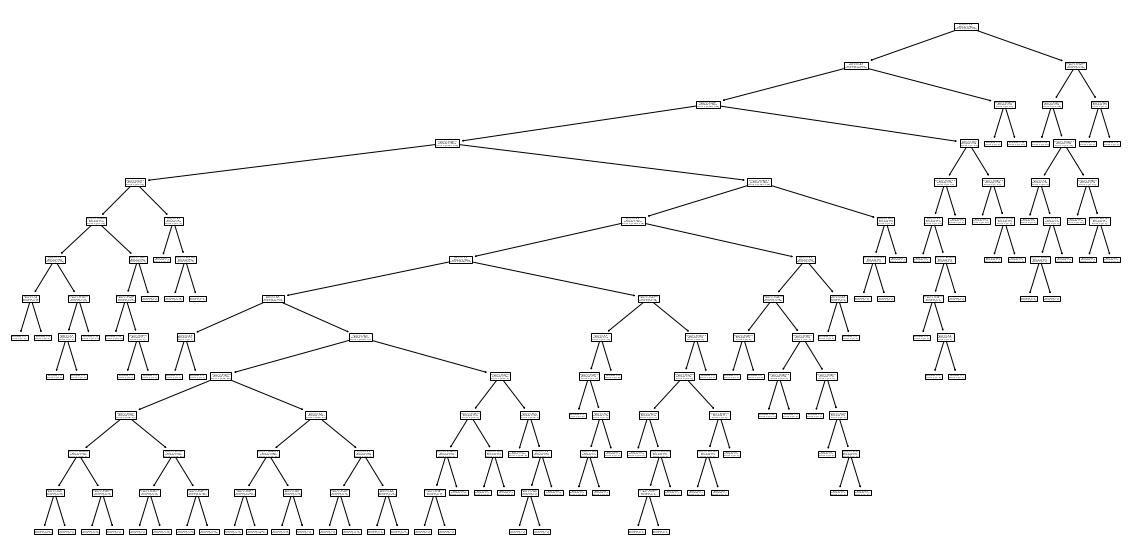

In [41]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(best_model_dt)
plt.show()

## Conclusiones

In [42]:
df = pd.concat([df_sgd_bm, df_dt_bm], axis=1)
#print(df)
df.columns = ['ScoreSGDBestParam', 'ScoreSGDDefault', 'SocreDTBestParam', 'ScoreDTDefault']
# tabla comparando scores de SGD y DT con valores por omisión:
print('Tabla de scores:')
display(df)

Tabla de scores:


,ScoreSGDBestParam,ScoreSGDDefault,SocreDTBestParam,ScoreDTDefault
ACCURACY_TRAIN,0.871207,0.866487,0.946055,1.000000
ACCURACY_TEST,0.881402,0.865229,0.911051,0.889488
PRECISION_TRAIN,0.884615,0.680272,0.977654,1.000000
PRECISION_TEST,0.888889,0.633333,0.790698,0.666667
RECALL_TRAIN,0.274900,0.398406,0.697211,1.000000
RECALL_TEST,0.275862,0.327586,0.586207,0.586207
F1_TRAIN,0.419453,0.502513,0.813953,1.000000
F1_TEST,0.421053,0.431818,0.673267,0.623853


En la tabla anterior podemos notar que aplicar un modelo de tipo *Arbol de Decision* es más eficiente que un modelo de *De Clasificación por Gradiente*. Concentrándonos en este último vemos que los hiper parámetros seleccionados para dicho modelo nos dan una probabilidad de acierto del 94.6055% en el dataset de entrenamiento y del 91.1051% en el dataset de test. Si bien en la cantidad de positivos propuestos por el modelo que fueron correctos (Precisión) el porcentaje es de 97.7654% en el dataset de entramiento y 79.0698% en el dataset de test, es menor al resultado del modelo SGD las demás métricas son superiores.  Es decir, la cantidad de positivos correctos que fueron encontrados por el modelo (recall) y media armonica entre ambas metricas (F1).
Dentro del mismo modelo se verifica que la optimización de hiper párametros presenta resultados más acertados que el uso de los hiper parámetros por defecto.